# Harry Potter Sorting Hat Classification

**problem definition**: predicting Hogwart's student house -  multiclass classification problem

**goal**: 90% accuracy


## Data:
 *   Index
 *   Hogwarts House
 *   First Name
 *   Last Name 
 *   Birthday 
 *   Best Hand
 *   Arithmancy
 *   Astronomy
 *   Herbology
 *   Defense Against the Dark Arts
 *  Divination
 *  Muggle Studies
 * Ancient Runes
 *  History of Magic
 *  Transfiguration
 *  Potions
 *  Care of Magical Creatures      
 *  Charms
 *  Flying

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

from sklearn.feature_selection import mutual_info_classif
from skfeature.function.similarity_based import fisher_score

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

# 1. Load data

In [3]:
df = pd.read_csv("Harry_Potter_students_dataset/dataset_train.csv")

In [4]:
df.head()

,Index,Hogwarts House,First Name,Last Name,Birthday,Best Hand,Arithmancy,Astronomy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Flying
0,0,Ravenclaw,Tamara,Hsu,2000-03-30,Left,58384.0,-487.886086,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,0.715939,-232.79405,-26.89
1,1,Slytherin,Erich,Paredes,1999-10-14,Right,67239.0,-552.060507,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,0.091674,-252.18425,-113.45
2,2,Ravenclaw,Stephany,Braun,1999-11-03,Left,23702.0,-366.076117,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,-0.515327,-227.34265,30.42
3,3,Gryffindor,Vesta,Mcmichael,2000-08-19,Left,32667.0,697.742809,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,-0.014040,-256.84675,200.64
4,4,Gryffindor,Gaston,Gibbs,1998-09-27,Left,60158.0,436.775204,-7.820623,NaN,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,-0.264070,-256.38730,157.98


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Index                          1600 non-null   int64  
 1   Hogwarts House                 1600 non-null   object 
 2   First Name                     1600 non-null   object 
 3   Last Name                      1600 non-null   object 
 4   Birthday                       1600 non-null   object 
 5   Best Hand                      1600 non-null   object 
 6   Arithmancy                     1566 non-null   float64
 7   Astronomy                      1568 non-null   float64
 8   Herbology                      1567 non-null   float64
 9   Defense Against the Dark Arts  1569 non-null   float64
 10  Divination                     1561 non-null   float64
 11  Muggle Studies                 1565 non-null   float64
 12  Ancient Runes                  1565 non-null   f

In [6]:
len(df)

1600

# 2. Data Preprocessing

## Handling missing values

In [7]:
missing_vals = pd.DataFrame(df.isna().sum())
missing_vals

,0
Index,0
Hogwarts House,0
First Name,0
Last Name,0
Birthday,0
Best Hand,0
Arithmancy,34
Astronomy,32
Herbology,33
Defense Against the Dark Arts,31


In [8]:
missing_vals_labels = missing_vals.index[missing_vals[0] != 0].tolist()
missing_vals_labels

['Arithmancy',
 'Astronomy',
 'Herbology',
 'Defense Against the Dark Arts',
 'Divination',
 'Muggle Studies',
 'Ancient Runes',
 'History of Magic',
 'Transfiguration',
 'Potions',
 'Care of Magical Creatures']

In [9]:
df[missing_vals_labels].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Arithmancy                     1566 non-null   float64
 1   Astronomy                      1568 non-null   float64
 2   Herbology                      1567 non-null   float64
 3   Defense Against the Dark Arts  1569 non-null   float64
 4   Divination                     1561 non-null   float64
 5   Muggle Studies                 1565 non-null   float64
 6   Ancient Runes                  1565 non-null   float64
 7   History of Magic               1557 non-null   float64
 8   Transfiguration                1566 non-null   float64
 9   Potions                        1570 non-null   float64
 10  Care of Magical Creatures      1560 non-null   float64
dtypes: float64(11)
memory usage: 137.6 KB


In [10]:
# Fill missing values with median if column has numeric content
for label, content in df[missing_vals_labels].items():
    if pd.api.types.is_numeric_dtype(content):
        df[label] = content.fillna(content.median())

In [11]:
df.isna().sum()

Index                            0
Hogwarts House                   0
First Name                       0
Last Name                        0
Birthday                         0
Best Hand                        0
Arithmancy                       0
Astronomy                        0
Herbology                        0
Defense Against the Dark Arts    0
Divination                       0
Muggle Studies                   0
Ancient Runes                    0
History of Magic                 0
Transfiguration                  0
Potions                          0
Care of Magical Creatures        0
Charms                           0
Flying                           0
dtype: int64

## Checking if any data is duplicated

Check if there is any column with the same value thoroguht all rows:

In [12]:
duplicated_col_to_drop = []
for label, content in df.items():
     if (len(df) - len(df[df[label].duplicated() == True][label])) == 1:
        duplicated_col_to_drop.append(label)

In [13]:
duplicated_col_to_drop

[]

Search for duplicated names:

In [14]:
df[df.duplicated(subset=["First Name", "Last Name"]) == True]

,Index,Hogwarts House,First Name,Last Name,Birthday,Best Hand,Arithmancy,Astronomy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Flying
740,740,Hufflepuff,Garry,Sonnier,1997-01-10,Right,34595.0,637.683165,2.269484,-6.376832,5.176,-362.212604,451.172967,6.681691,1034.971917,9.107222,0.092942,-244.76615,13.38


In [15]:
df[df["Last Name"] == "Sonnier"]

,Index,Hogwarts House,First Name,Last Name,Birthday,Best Hand,Arithmancy,Astronomy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Flying
341,341,Slytherin,Garry,Sonnier,1997-08-23,Right,47990.0,-510.185649,-6.913139,5.101856,4.624,-372.364583,420.166360,5.867128,1045.456870,11.023966,-0.067032,-250.34131,-81.89
740,740,Hufflepuff,Garry,Sonnier,1997-01-10,Right,34595.0,637.683165,2.269484,-6.376832,5.176,-362.212604,451.172967,6.681691,1034.971917,9.107222,0.092942,-244.76615,13.38


# 3. EDA

In [16]:
df["Hogwarts House"].value_counts() # target

Hogwarts House
Hufflepuff    529
Ravenclaw     443
Gryffindor    327
Slytherin     301
Name: count, dtype: int64

### Hogwart's House based on Best Hand

In [17]:
df["Best Hand"].value_counts()

Best Hand
Right    810
Left     790
Name: count, dtype: int64

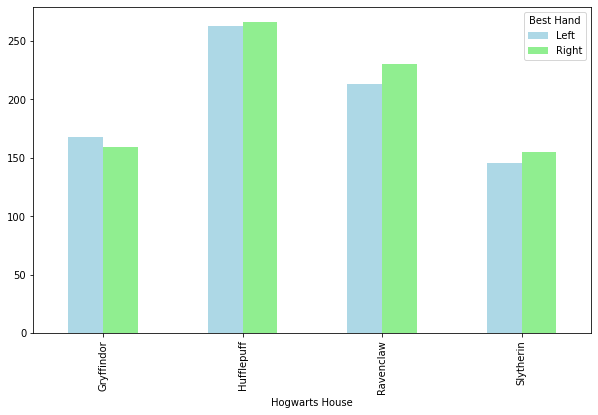

In [18]:
pd.crosstab(df["Hogwarts House"], df["Best Hand"]).plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightgreen']);

Gryffindor - more left handed

### Students birthday analysis

In [19]:
df["Birthday"].dtype

dtype('O')

In [20]:
df["Birthday"] = pd.to_datetime(df["Birthday"])

In [21]:
df["Birthday Year"] = df["Birthday"].dt.year

In [22]:
df["Birthday Month"] = df["Birthday"].dt.month
df["Birthday Day"] = df["Birthday"].dt.day

In [23]:
df.drop("Birthday", axis=1, inplace=True)

In [24]:
df.head()

,Index,Hogwarts House,First Name,Last Name,Best Hand,Arithmancy,Astronomy,Herbology,Defense Against the Dark Arts,Divination,...,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Flying,Birthday Year,Birthday Month,Birthday Day
0,0,Ravenclaw,Tamara,Hsu,Left,58384.0,-487.886086,5.727180,4.878861,4.722,...,532.484226,5.231058,1039.788281,3.790369,0.715939,-232.79405,-26.89,2000,3,30
1,1,Slytherin,Erich,Paredes,Right,67239.0,-552.060507,-5.987446,5.520605,-5.612,...,367.760303,4.107170,1058.944592,7.248742,0.091674,-252.18425,-113.45,1999,10,14
2,2,Ravenclaw,Stephany,Braun,Left,23702.0,-366.076117,7.725017,3.660761,6.140,...,602.585284,3.555579,1088.088348,8.728531,-0.515327,-227.34265,30.42,1999,11,3
3,3,Gryffindor,Vesta,Mcmichael,Left,32667.0,697.742809,-6.497214,-6.977428,4.026,...,523.982133,-4.809637,920.391449,0.821911,-0.014040,-256.84675,200.64,2000,8,19
4,4,Gryffindor,Gaston,Gibbs,Left,60158.0,436.775204,-7.820623,-2.589342,2.236,...,599.324514,-3.444377,937.434724,4.311066,-0.264070,-256.38730,157.98,1998,9,27


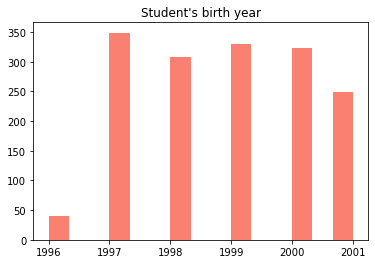

In [25]:
plt.hist(df["Birthday Year"], color="salmon", bins=15);
plt.title("Student's birth year");

In [26]:
(pd.crosstab(df["Birthday Year"], df["Hogwarts House"])/len(df))*100

Hogwarts House,Gryffindor,Hufflepuff,Ravenclaw,Slytherin
Birthday Year,,,,
1996,0.5000,0.9375,0.6875,0.3750
1997,4.5000,8.0625,5.1875,4.0625
1998,4.6875,5.5000,4.3750,4.6875
1999,4.1875,7.0625,5.9375,3.4375
2000,3.0625,6.8125,6.8125,3.5625
2001,3.5000,4.6875,4.6875,2.6875


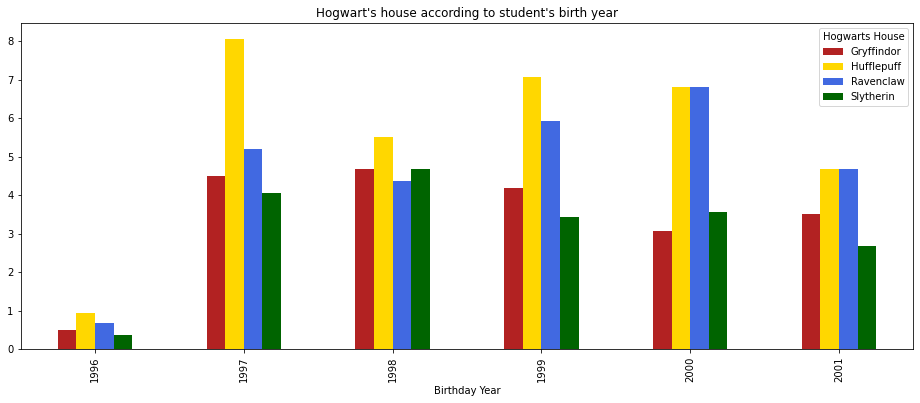

In [27]:
((pd.crosstab(df["Birthday Year"], df["Hogwarts House"])/len(df))*100).plot(kind='bar', figsize = (16, 6), color=['firebrick', 'gold', 'royalblue', 'darkgreen']);
plt.title("Hogwart's house according to student's birth year");

Every year hufflepuff the most common house

In [28]:
(pd.crosstab(df["Birthday Month"], df["Hogwarts House"])/len(df))*100

Hogwarts House,Gryffindor,Hufflepuff,Ravenclaw,Slytherin
Birthday Month,,,,
1,2.1250,2.6250,2.0000,2.0000
2,1.2500,2.0000,2.0000,1.1875
3,1.8125,2.1875,3.2500,1.8125
4,1.8125,2.8750,2.3750,1.1875
5,2.0625,2.8125,2.1875,1.7500
6,1.3125,3.7500,1.9375,1.5000
7,1.5000,2.5000,2.0625,1.7500
8,1.4375,2.7500,2.3125,2.0000
9,1.8750,2.9375,2.5000,2.0000


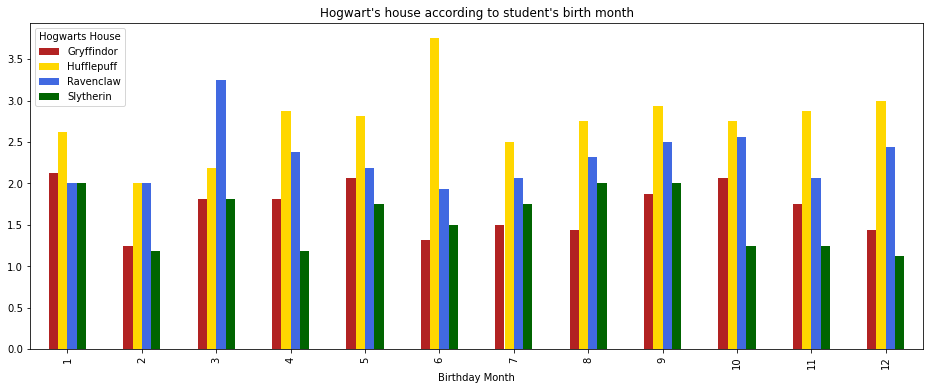

In [29]:
((pd.crosstab(df["Birthday Month"], df["Hogwarts House"])/len(df))*100).plot(kind='bar', figsize = (16, 6), color=['firebrick', 'gold', 'royalblue', 'darkgreen']);
plt.title("Hogwart's house according to student's birth month");

* Most ravenclaws in March
* Most hufflepuffs in June

## Best scores in subjects analysis

In [30]:
subjects = ["Arithmancy", "Astronomy", "Herbology", "Defense Against the Dark Arts", "Divination",
           "Muggle Studies", "Ancient Runes", "History of Magic", "Transfiguration", "Potions",
           "Care of Magical Creatures", "Charms", "Flying"]

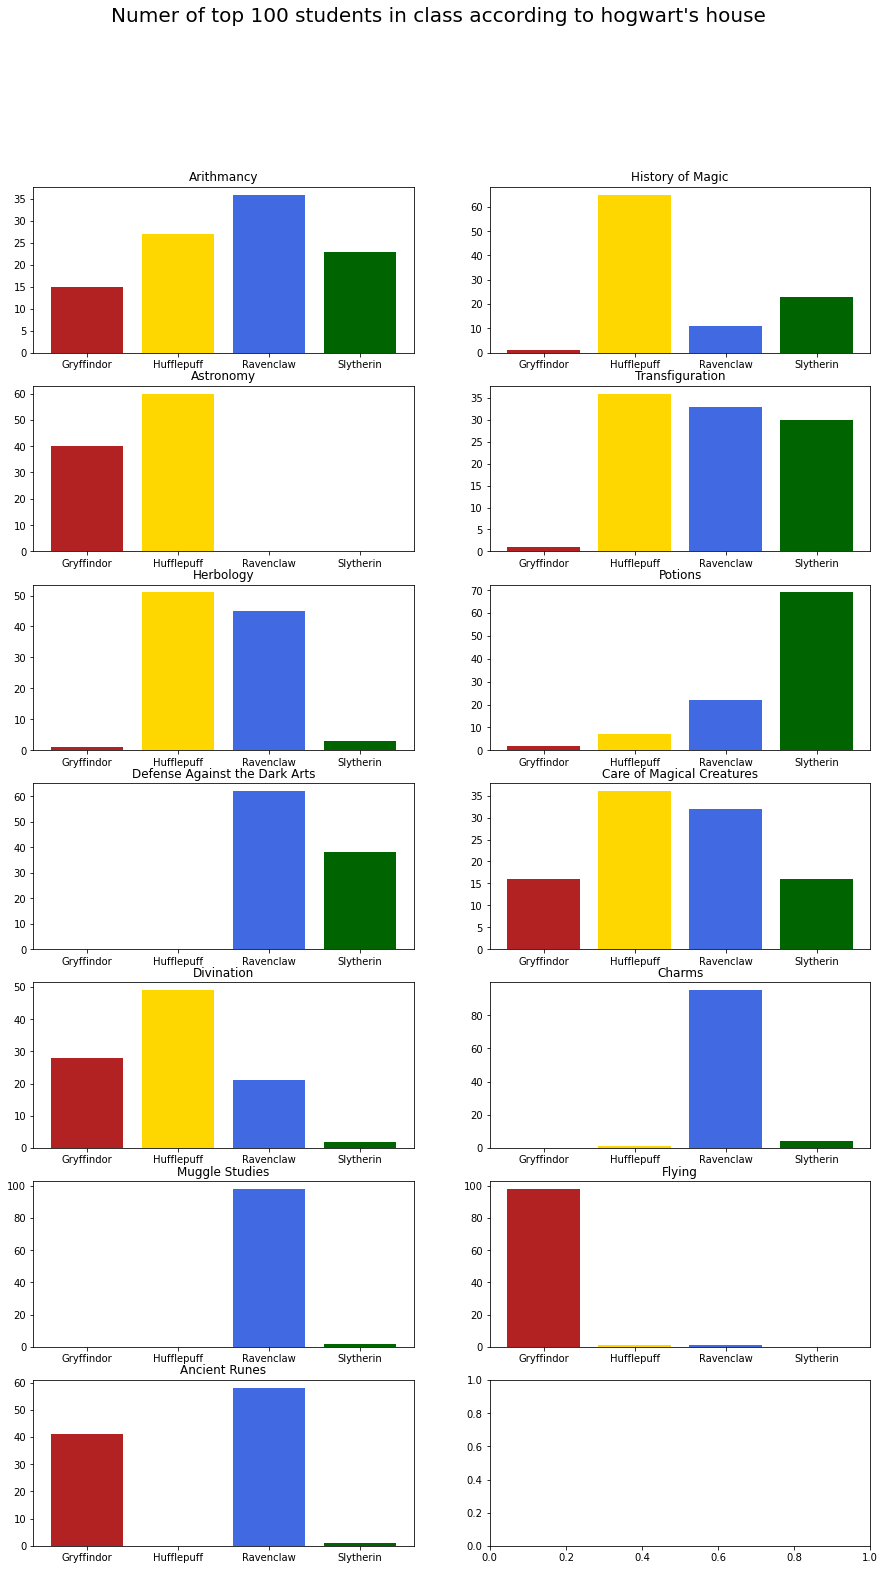

In [31]:
subject_best_students = []

fig,axs = plt.subplots(round((len(subjects)/2))+1, 2, figsize=(15,25))
fig.suptitle("Numer of top 100 students in class according to hogwart's house", fontsize=20);
for i, subject in enumerate(subjects):
    
    subject_ct = (pd.crosstab(df[subject], df["Hogwarts House"]))
    subject_ct = subject_ct.sort_index(ascending=False)
    subject_ct_top = subject_ct.iloc[:100]
    subject_ct_top.index = np.arange(1,101,1)
    subject_ct_top = subject_ct_top[subject_ct_top>0].count()
    
    subject_best_students.append(subject_ct_top)
    
    if(i<=round((len(subjects)/2))):
        axs[i,0].bar(subject_ct_top.index, height=subject_ct_top, color=['firebrick', 'gold', 'royalblue', 'darkgreen']);
        axs[i,0].set_title(subject);
    else:
        axs[i-(round((len(subjects)/2))+1),1].bar(subject_ct_top.index, height=subject_ct_top, color=['firebrick', 'gold', 'royalblue', 'darkgreen']);
        axs[i-(round((len(subjects)/2))+1),1].set_title(subject);


* Slytherins best at Potions
* Gryffindors best at Flying
* Best at Defence Against The Dark Arts tend to do worse at Astronomy

Slytherins good at: Arithmancy, Transfiguration, Potions, Defense Against the Dark Arts, History of Magic

Gryffindors good at: Arithmancy, Astronomy, Care of Magical Creatures, Divination, Flying, Ancient Runes

Ravenclaws good at: Arithmancy, History of Magic, Transfiguration, Herbology, Potions, Defense Against the Dark Arts, Care of Magical Creatures, Divination, Charms, Muggle Studies, Ancient Runes

Hufflepuffs good at: Arithmancy, Astronomy, Herbology, Divination, History of Magic, Transfiguration, Potions, Care of Magical Creatures

In [32]:
# Checking number of students from each house that are in top 100 students

num_of_students_in_top = {}
num_of_students_in_top["Gryffindor"] = np.sum([subject_best_students[i].loc["Gryffindor"] for i in range(len(subject_best_students))])
num_of_students_in_top["Slytherin"] = np.sum([subject_best_students[i].loc["Slytherin"] for i in range(len(subject_best_students))])
num_of_students_in_top["Ravenclaw"] = np.sum([subject_best_students[i].loc["Ravenclaw"] for i in range(len(subject_best_students))])
num_of_students_in_top["Hufflepuff"] = np.sum([subject_best_students[i].loc["Hufflepuff"] for i in range(len(subject_best_students))])
sorted(num_of_students_in_top.items(), key= lambda x: x[1], reverse=True)

[('Ravenclaw', 514),
 ('Hufflepuff', 333),
 ('Gryffindor', 243),
 ('Slytherin', 211)]

Ravenclaw has the best students, slytherin the worst

### Correlation matrix

In [33]:
df.head()

,Index,Hogwarts House,First Name,Last Name,Best Hand,Arithmancy,Astronomy,Herbology,Defense Against the Dark Arts,Divination,...,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Flying,Birthday Year,Birthday Month,Birthday Day
0,0,Ravenclaw,Tamara,Hsu,Left,58384.0,-487.886086,5.727180,4.878861,4.722,...,532.484226,5.231058,1039.788281,3.790369,0.715939,-232.79405,-26.89,2000,3,30
1,1,Slytherin,Erich,Paredes,Right,67239.0,-552.060507,-5.987446,5.520605,-5.612,...,367.760303,4.107170,1058.944592,7.248742,0.091674,-252.18425,-113.45,1999,10,14
2,2,Ravenclaw,Stephany,Braun,Left,23702.0,-366.076117,7.725017,3.660761,6.140,...,602.585284,3.555579,1088.088348,8.728531,-0.515327,-227.34265,30.42,1999,11,3
3,3,Gryffindor,Vesta,Mcmichael,Left,32667.0,697.742809,-6.497214,-6.977428,4.026,...,523.982133,-4.809637,920.391449,0.821911,-0.014040,-256.84675,200.64,2000,8,19
4,4,Gryffindor,Gaston,Gibbs,Left,60158.0,436.775204,-7.820623,-2.589342,2.236,...,599.324514,-3.444377,937.434724,4.311066,-0.264070,-256.38730,157.98,1998,9,27


In [34]:
df.drop('Index', axis=1, inplace=True)

In [35]:
def get_numeric_cols(df):
    '''
    returns list of numeric columns in given dataframe
    '''
    num_cols=[]
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            num_cols.append(label)
    return num_cols

In [36]:
num_cols = get_numeric_cols(df)

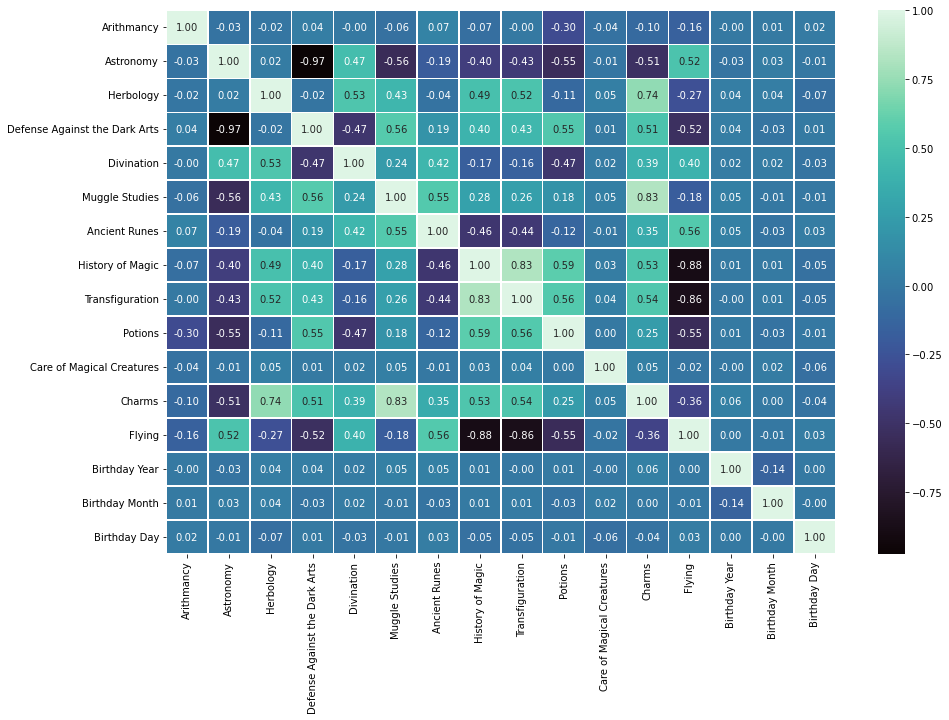

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[num_cols].corr(), annot=True, linewidths=0.5, fmt='.2f', cmap='mako');

* Students better at Astronomy are significantly worse at Defense Against the Dark Arts and tend to be a little worse at: Muggle Studies, Potions, Charms and better at flying
* Students better at Herbology tend to be better at Charms, Transfiguration and Divination
* Students better at Defense Against the Dark Arts are worse at Flying, Astronomy and better at Charms, Potions, Muggle Studies
* Students better at Divination are better at Herbology
* Students better at Muggle Studies are significantly better at Charms, better at Ancient Runes, Defense Against the Dark Arts and wrose at Astronomy
* Students better at Ancient Runes are better at Flying, Muggle Studies
* Students better at History of Magic are significanly worse at Flying, significantly better at Transfiguration, and better at Potions, Charms
* Students better at Transfiguration are significantly worse at Flying, significantly better at History of Magic, better at Herbology, Potions, Charms
* Students better at Potions are worse at Astronomy, Flying and better at Transfiguration, History of Magic, Defense Against the Dark Arts
* Students better at Charms are wrose at Astronomy, significantly better at Muggle Studies, better at Transfiguration, History of Magic, Defense Against the Dark Arts, Herbology
* Students better at Flying are significantly worse at Transfiguration, History of Magic, worse at Defense Against the Dark Arts, Potions and better at Ancient Runes, Astronomy

In [38]:
# plt.figure(figsize=(15,8));
# sns.pairplot(df[num_cols]);

## Feature Engineering

**1) Good_at_astronomy**
* 1 if score >= mean
* 0 if score < mean

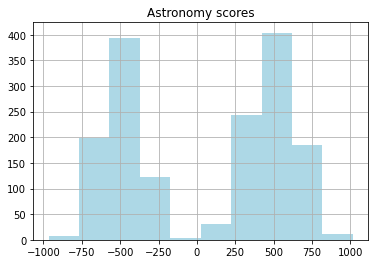

In [39]:
df["Astronomy"].hist(color='lightblue');
plt.title("Astronomy scores");

In [40]:
astronomy_mean = df["Astronomy"].mean()
astronomy_mean

44.20697720085449

In [41]:
df["Good_at_astronomy"] = None

In [42]:
df["Good_at_astronomy"].loc[df[df["Astronomy"]>=astronomy_mean].index] = 1
df["Good_at_astronomy"].loc[df[df["Astronomy"]<astronomy_mean].index] = 0

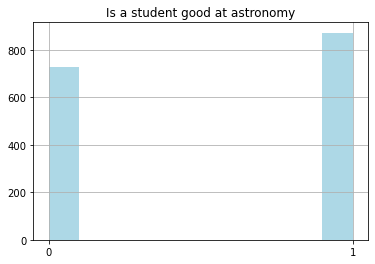

In [43]:
df["Good_at_astronomy"].hist(color='lightblue');
plt.title("Is a student good at astronomy");
plt.xticks([0,1]);

In [44]:
df["Good_at_astronomy"]=df["Good_at_astronomy"].astype('int')

In [45]:
# scores in Astronomy not needed anymore -> drop
df.drop("Astronomy", axis=1, inplace=True)

**2) Good_at_flying**
* 1 if score >= mean
* 0 if score < mean

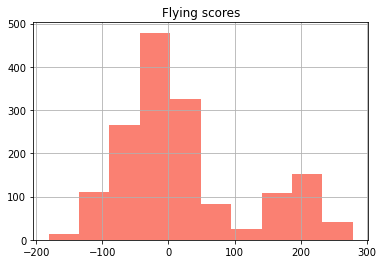

In [46]:
df["Flying"].hist(color='salmon');
plt.title("Flying scores");

In [47]:
flying_mean = df["Flying"].mean()
flying_mean

21.9580125

In [48]:
df["Good_at_flying"] = None
df["Good_at_flying"].loc[df[df["Flying"]>=flying_mean].index] = 1
df["Good_at_flying"].loc[df[df["Flying"]<flying_mean].index] = 0

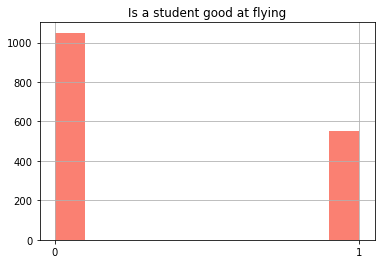

In [49]:
df["Good_at_flying"].hist(color='salmon');
plt.title("Is a student good at flying");
plt.xticks([0,1]);

In [50]:
df["Good_at_flying"]=df["Good_at_flying"].astype('int')

In [51]:
# scores in Flying not needed anymore -> drop
df.drop("Flying", axis=1, inplace=True)

In [52]:
num_cols = get_numeric_cols(df)

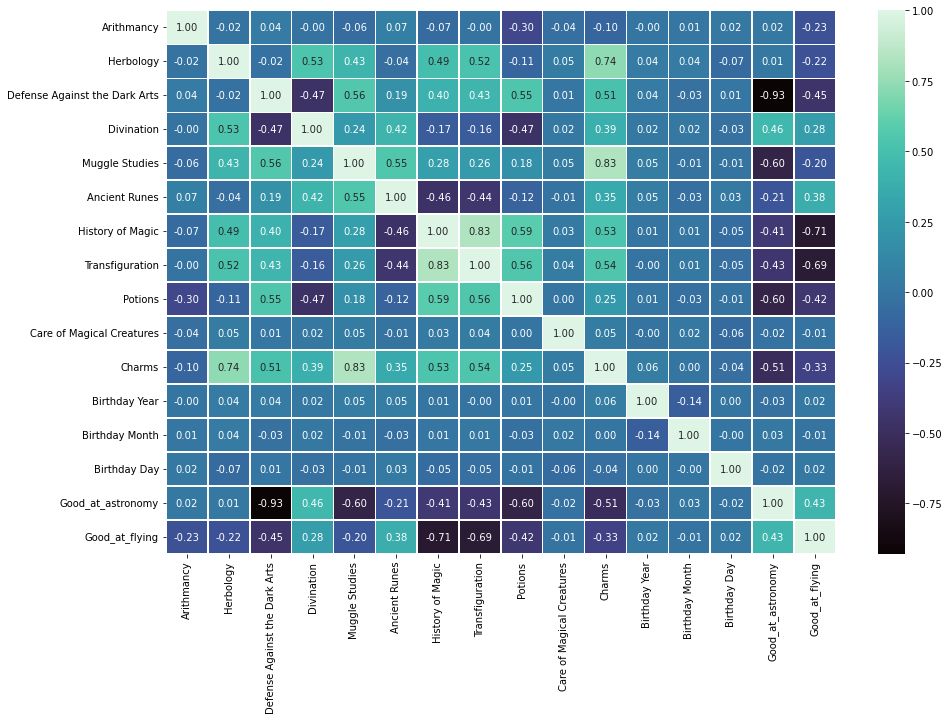

In [53]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[num_cols].corr(), annot=True, linewidths=0.5, fmt='.2f', cmap='mako');

# Truning categorical data into binary

In [54]:
df_to_encode = df.drop(num_cols, axis=1)
df_to_encode

,Hogwarts House,First Name,Last Name,Best Hand
0,Ravenclaw,Tamara,Hsu,Left
1,Slytherin,Erich,Paredes,Right
2,Ravenclaw,Stephany,Braun,Left
3,Gryffindor,Vesta,Mcmichael,Left
4,Gryffindor,Gaston,Gibbs,Left
...,...,...,...,...
1595,Gryffindor,Jung,Blank,Right
1596,Slytherin,Shelli,Lock,Left
1597,Gryffindor,Benjamin,Christensen,Right
1598,Hufflepuff,Charlotte,Dillon,Left


Truning "Best Hand" into binary:
* Left hand - 0
* Right hand - 1

In [55]:
df["Best Hand"].value_counts()

Best Hand
Right    810
Left     790
Name: count, dtype: int64

In [56]:
df["Best Hand"].loc[df[df["Best Hand"] == "Right"].index] = 1
df["Best Hand"].loc[df[df["Best Hand"] == "Left"].index] = 0

In [57]:
df["Best Hand"].value_counts()

Best Hand
1    810
0    790
Name: count, dtype: int64

In [58]:
df["Best Hand"]=df["Best Hand"].astype('int')

Checking column with first names:

In [59]:
df["First Name"].value_counts() # no useful data -> drop

First Name
Tiffany    6
Marty      5
Joseph     5
Laverne    5
Darwin     4
          ..
Kathy      1
Shantel    1
Tina       1
Stefan     1
Shelli     1
Name: count, Length: 1215, dtype: int64

In [60]:
df.drop("First Name", axis=1, inplace=True)

Checking colmuns with last name:

In [61]:
df["Last Name"].value_counts() # no useful data -> drop

Last Name
Stewart      4
Maldonado    3
Allen        3
Champion     3
Sawyers      3
            ..
Bray         1
Mcnulty      1
Isbell       1
Ballou       1
Nowak        1
Name: count, Length: 1378, dtype: int64

In [62]:
df.drop("Last Name", axis=1, inplace=True)

Checking for any left categorical features

In [63]:
df

,Hogwarts House,Best Hand,Arithmancy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Birthday Year,Birthday Month,Birthday Day,Good_at_astronomy,Good_at_flying
0,Ravenclaw,0,58384.0,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,0.715939,-232.79405,2000,3,30,0,0
1,Slytherin,1,67239.0,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,0.091674,-252.18425,1999,10,14,0,0
2,Ravenclaw,0,23702.0,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,-0.515327,-227.34265,1999,11,3,0,1
3,Gryffindor,0,32667.0,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,-0.014040,-256.84675,2000,8,19,1,1
4,Gryffindor,0,60158.0,-7.820623,-2.589342,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,-0.264070,-256.38730,1998,9,27,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,Gryffindor,1,49009.0,-4.541837,-3.542801,5.702,-497.235066,618.220213,-5.231721,964.219853,3.389086,-0.649983,-250.39401,2001,9,14,1,1
1596,Slytherin,0,63296.0,6.061064,-3.675312,1.757,-643.271092,445.827565,2.238112,1056.147366,5.825263,-0.333962,-246.42719,1998,3,12,1,1
1597,Gryffindor,1,63905.0,-3.203269,-5.440189,6.065,-385.150457,635.211486,-5.984257,953.866685,1.709808,0.071569,-251.63679,1999,10,24,1,1
1598,Hufflepuff,0,82713.0,3.442831,-4.536762,6.738,-831.741123,383.444937,3.813111,1087.949205,3.904100,-0.531875,-246.19072,2001,9,21,1,0


In [64]:
df["Birthday Year"] = df["Birthday Year"].astype('category')
df["Birthday Month"] = df["Birthday Month"].astype('category')

Truning "Birthday Day" into binary feature **born_in_1st_half_of_month**:
* yes - 1
* no - 0

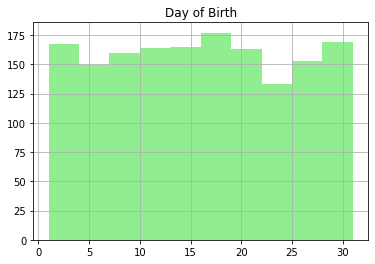

In [65]:
df["Birthday Day"].hist(color='lightgreen');
plt.title("Day of Birth");

In [66]:
df["born_in_1st_half_of_month"]=None
df["born_in_1st_half_of_month"].loc[df[df["Birthday Day"] <=15].index] = 1
df["born_in_1st_half_of_month"].loc[df[df["Birthday Day"] >15].index] = 0

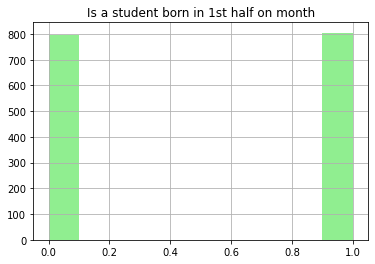

In [67]:
df["born_in_1st_half_of_month"].hist(color='lightgreen');
plt.title("Is a student born in 1st half on month");

In [68]:
df.drop("Birthday Day", axis=1, inplace=True) # Birth daty no longer needed

In [69]:
df["born_in_1st_half_of_month"] = df["born_in_1st_half_of_month"].astype('int')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Hogwarts House                 1600 non-null   object  
 1   Best Hand                      1600 non-null   int32   
 2   Arithmancy                     1600 non-null   float64 
 3   Herbology                      1600 non-null   float64 
 4   Defense Against the Dark Arts  1600 non-null   float64 
 5   Divination                     1600 non-null   float64 
 6   Muggle Studies                 1600 non-null   float64 
 7   Ancient Runes                  1600 non-null   float64 
 8   History of Magic               1600 non-null   float64 
 9   Transfiguration                1600 non-null   float64 
 10  Potions                        1600 non-null   float64 
 11  Care of Magical Creatures      1600 non-null   float64 
 12  Charms                         160

In [71]:
df["Hogwarts House"] = df["Hogwarts House"].astype('category')

In [72]:
num_cols = get_numeric_cols(df)
num_cols

['Best Hand',
 'Arithmancy',
 'Herbology',
 'Defense Against the Dark Arts',
 'Divination',
 'Muggle Studies',
 'Ancient Runes',
 'History of Magic',
 'Transfiguration',
 'Potions',
 'Care of Magical Creatures',
 'Charms',
 'Good_at_astronomy',
 'Good_at_flying',
 'born_in_1st_half_of_month']

In [73]:
df_to_encode = df.drop(num_cols+["Hogwarts House"], axis=1)
df_to_encode

,Birthday Year,Birthday Month
0,2000,3
1,1999,10
2,1999,11
3,2000,8
4,1998,9
...,...,...
1595,2001,9
1596,1998,3
1597,1999,10
1598,2001,9


### One Hot encoder

In [74]:
one_hot = OneHotEncoder()

one_hot_arr = one_hot.fit_transform(df_to_encode).toarray()
one_hot_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [75]:
one_hot_labels_arr = one_hot.categories_
one_hot_labels_arr

[array([1996, 1997, 1998, 1999, 2000, 2001]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]

In [76]:
one_hot_labels = []
counter = 0
for i in range(len(one_hot_labels_arr)):
    one_hot_labels.extend([x+"_"+df_to_encode.columns[counter] for x in [str(x) for x in list(one_hot_labels_arr[i])]])
    counter+=1

In [77]:
one_hot_labels

['1996_Birthday Year',
 '1997_Birthday Year',
 '1998_Birthday Year',
 '1999_Birthday Year',
 '2000_Birthday Year',
 '2001_Birthday Year',
 '1_Birthday Month',
 '2_Birthday Month',
 '3_Birthday Month',
 '4_Birthday Month',
 '5_Birthday Month',
 '6_Birthday Month',
 '7_Birthday Month',
 '8_Birthday Month',
 '9_Birthday Month',
 '10_Birthday Month',
 '11_Birthday Month',
 '12_Birthday Month']

In [78]:
one_hot_encoded_data = pd.DataFrame(one_hot_arr, columns = one_hot_labels)
one_hot_encoded_data

,1996_Birthday Year,1997_Birthday Year,1998_Birthday Year,1999_Birthday Year,2000_Birthday Year,2001_Birthday Year,1_Birthday Month,2_Birthday Month,3_Birthday Month,4_Birthday Month,5_Birthday Month,6_Birthday Month,7_Birthday Month,8_Birthday Month,9_Birthday Month,10_Birthday Month,11_Birthday Month,12_Birthday Month
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1596,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1598,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [79]:
df_encoded = pd.concat([df[num_cols], one_hot_encoded_data], axis=1)

In [80]:
df_encoded # without target

,Best Hand,Arithmancy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,...,3_Birthday Month,4_Birthday Month,5_Birthday Month,6_Birthday Month,7_Birthday Month,8_Birthday Month,9_Birthday Month,10_Birthday Month,11_Birthday Month,12_Birthday Month
0,0,58384.0,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,67239.0,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,23702.0,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,32667.0,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,60158.0,-7.820623,-2.589342,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1,49009.0,-4.541837,-3.542801,5.702,-497.235066,618.220213,-5.231721,964.219853,3.389086,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1596,0,63296.0,6.061064,-3.675312,1.757,-643.271092,445.827565,2.238112,1056.147366,5.825263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,1,63905.0,-3.203269,-5.440189,6.065,-385.150457,635.211486,-5.984257,953.866685,1.709808,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1598,0,82713.0,3.442831,-4.536762,6.738,-831.741123,383.444937,3.813111,1087.949205,3.904100,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


###  Transforming Target

* Hufflepuff: 0
* Ravenclaw: 1
* Gryffindor: 2
* Slytherin: 3

In [81]:
df_encoded["Hogwarts House"] = df["Hogwarts House"]

In [82]:
df_encoded["Hogwarts House"] = df_encoded["Hogwarts House"].replace({"Hufflepuff": 0, "Ravenclaw": 1, "Gryffindor": 2, "Slytherin": 3})

In [83]:
df_encoded["Hogwarts House"].value_counts()

Hogwarts House
0    529
1    443
2    327
3    301
Name: count, dtype: int64

# Outliers

In [84]:
# list of binary numerical columns
cols_binary = []
for label in df[num_cols]:
    if (list(df[label].value_counts().index) == [0,1]) | (list(df[label].value_counts().index) == [1,0]):
        cols_binary.append(label)

In [85]:
cols_binary

['Best Hand',
 'Good_at_astronomy',
 'Good_at_flying',
 'born_in_1st_half_of_month']

In [86]:
cat_cols = list(one_hot_encoded_data.columns)

In [87]:
df_check_outliers = df_encoded.drop(cols_binary + cat_cols + ["Hogwarts House"], axis=1)
df_check_outliers

,Arithmancy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms
0,58384.0,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,0.715939,-232.79405
1,67239.0,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,0.091674,-252.18425
2,23702.0,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,-0.515327,-227.34265
3,32667.0,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,-0.014040,-256.84675
4,60158.0,-7.820623,-2.589342,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,-0.264070,-256.38730
...,...,...,...,...,...,...,...,...,...,...,...
1595,49009.0,-4.541837,-3.542801,5.702,-497.235066,618.220213,-5.231721,964.219853,3.389086,-0.649983,-250.39401
1596,63296.0,6.061064,-3.675312,1.757,-643.271092,445.827565,2.238112,1056.147366,5.825263,-0.333962,-246.42719
1597,63905.0,-3.203269,-5.440189,6.065,-385.150457,635.211486,-5.984257,953.866685,1.709808,0.071569,-251.63679
1598,82713.0,3.442831,-4.536762,6.738,-831.741123,383.444937,3.813111,1087.949205,3.904100,-0.531875,-246.19072


### Interqurtile range

In [88]:
low_limit={}
up_limit={}
for label in df_check_outliers.columns:
    
    Q1 = np.percentile(df_check_outliers[label], 25, interpolation = 'midpoint')
    Q3 = np.percentile(df_check_outliers[label], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    low_limit[label] = Q1 - 1.5 * IQR
    up_limit[label] = Q3 + 1.5 * IQR

In [89]:
low_limit

{'Arithmancy': 6030.0,
 'Herbology': -18.686733964961597,
 'Defense Against the Dark Arts': -20.318120580837007,
 'Divination': -0.5422499999999997,
 'Muggle Studies': -1795.4286898555483,
 'Ancient Runes': 100.89102279539696,
 'History of Magic': -2.5496551156706078,
 'Transfiguration': 980.1870817683575,
 'Potions': -3.1217227164055763,
 'Care of Magical Creatures': -2.4915140328941234,
 'Charms': -277.824145}

In [90]:
up_limit

{'Arithmancy': 93254.0,
 'Herbology': 19.834114843908782,
 'Defense Against the Dark Arts': 19.991944215215224,
 'Divination': 9.34375,
 'Muggle Studies': 1460.219908935228,
 'Ancient Runes': 894.5708464288537,
 'History of Magic': 10.74397853205862,
 'Transfiguration': 1104.973250102923,
 'Potions': 15.027290059173598,
 'Care of Magical Creatures': 2.4158665957708827,
 'Charms': -205.38090500000004}

In [91]:
is_outlier = pd.DataFrame(np.zeros(df_check_outliers.shape), columns=df_check_outliers.columns)
for label in df_check_outliers.columns:
    for i in range(len(df_check_outliers)):
        if ((df_check_outliers[label].iloc[i]>up_limit[label]) | (df_check_outliers[label].iloc[i]<low_limit[label])):
            is_outlier[label].iloc[i] = 1

In [92]:
# Number of outliers for each column in %
outliers_dict = round(is_outlier[is_outlier==1].count()/len(df_check_outliers), 2)*100
outliers_dict

Arithmancy                        1.0
Herbology                         0.0
Defense Against the Dark Arts     0.0
Divination                       18.0
Muggle Studies                    0.0
Ancient Runes                     0.0
History of Magic                 19.0
Transfiguration                  19.0
Potions                           0.0
Care of Magical Creatures         1.0
Charms                            0.0
dtype: float64

In [93]:
outliers_labels = list(outliers_dict[outliers_dict !=0].keys())
outliers_labels

['Arithmancy',
 'Divination',
 'History of Magic',
 'Transfiguration',
 'Care of Magical Creatures']

In [94]:
list(enumerate(outliers_labels))

[(0, 'Arithmancy'),
 (1, 'Divination'),
 (2, 'History of Magic'),
 (3, 'Transfiguration'),
 (4, 'Care of Magical Creatures')]

Fill outliers with median

In [95]:
df_check_outliers_filled = df_check_outliers.copy()

for label in outliers_labels:
    for i in range(len(df_check_outliers)):
        if is_outlier[label].iloc[i]==1:
            df_check_outliers_filled[label].iloc[i] = df_check_outliers[label].median()

Checking outliers after filling them with median

In [96]:
is_outlier_after = pd.DataFrame(np.zeros(df_check_outliers.shape), columns=df_check_outliers.columns)
for label in df_check_outliers_filled.columns:
    for i in range(len(df_check_outliers_filled)):
        if ((df_check_outliers_filled[label].iloc[i]>up_limit[label]) | (df_check_outliers_filled[label].iloc[i]<low_limit[label])):
            is_outlier[label].iloc[i] = 1

In [97]:
# Number of outliers for each column in %
outliers_dict_after = round(is_outlier_after[is_outlier_after==1].count()/len(df_check_outliers_filled), 2)*100
outliers_dict_after

Arithmancy                       0.0
Herbology                        0.0
Defense Against the Dark Arts    0.0
Divination                       0.0
Muggle Studies                   0.0
Ancient Runes                    0.0
History of Magic                 0.0
Transfiguration                  0.0
Potions                          0.0
Care of Magical Creatures        0.0
Charms                           0.0
dtype: float64

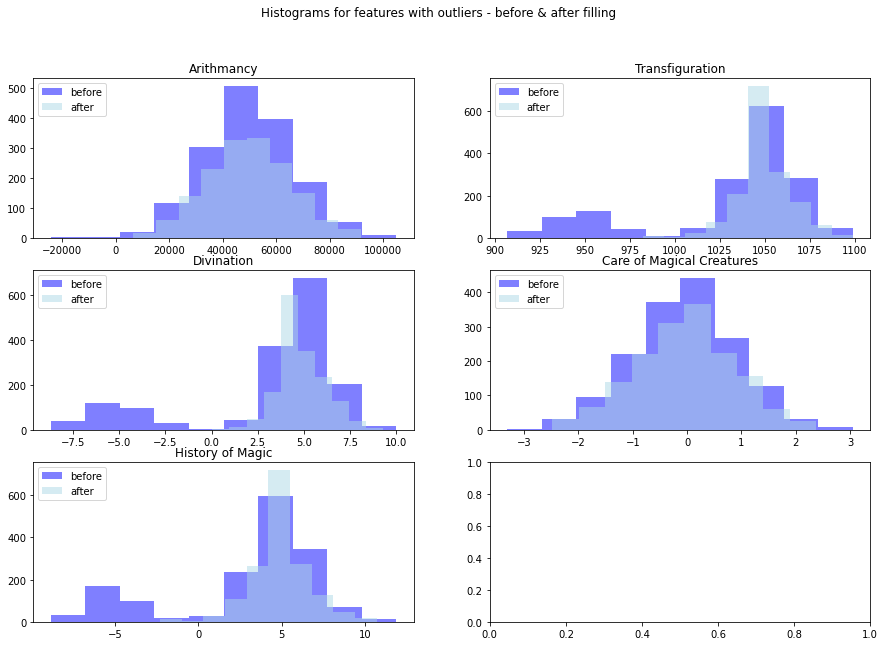

In [98]:
fig, axs = plt.subplots(round(len(outliers_labels)/2)+1,2,figsize=(15,10))
plt.suptitle("Histograms for features with outliers - before & after filling")
for i, label in enumerate(outliers_labels):
    if i<=round(len(outliers_labels)/2):
        axs[i, 0].hist(df_check_outliers[label], color='blue', alpha=0.5, label="before")
        axs[i, 0].hist(df_check_outliers_filled[label], color='lightblue', alpha=0.5, label="after")
        axs[i, 0].set_title(label)
        axs[i, 0].legend(loc='upper left');
    else:
        axs[i-(round(len(outliers_labels)/2)+1), 1].hist(df_check_outliers[label], color='blue', alpha=0.5, label="before")
        axs[i-(round(len(outliers_labels)/2)+1), 1].hist(df_check_outliers_filled[label], color='lightblue', alpha=0.5, label="after")
        axs[i-(round(len(outliers_labels)/2)+1), 1].set_title(label)
        axs[i-(round(len(outliers_labels)/2)+1), 1].legend(loc='upper left');

In [99]:
df_encoded[df_check_outliers_filled.columns] = df_check_outliers_filled

Checking histograms for all numeric features

In [100]:
num_cols_encoded = df_check_outliers.columns

In [101]:
df_num_cols_encoded = df_encoded[num_cols_encoded]

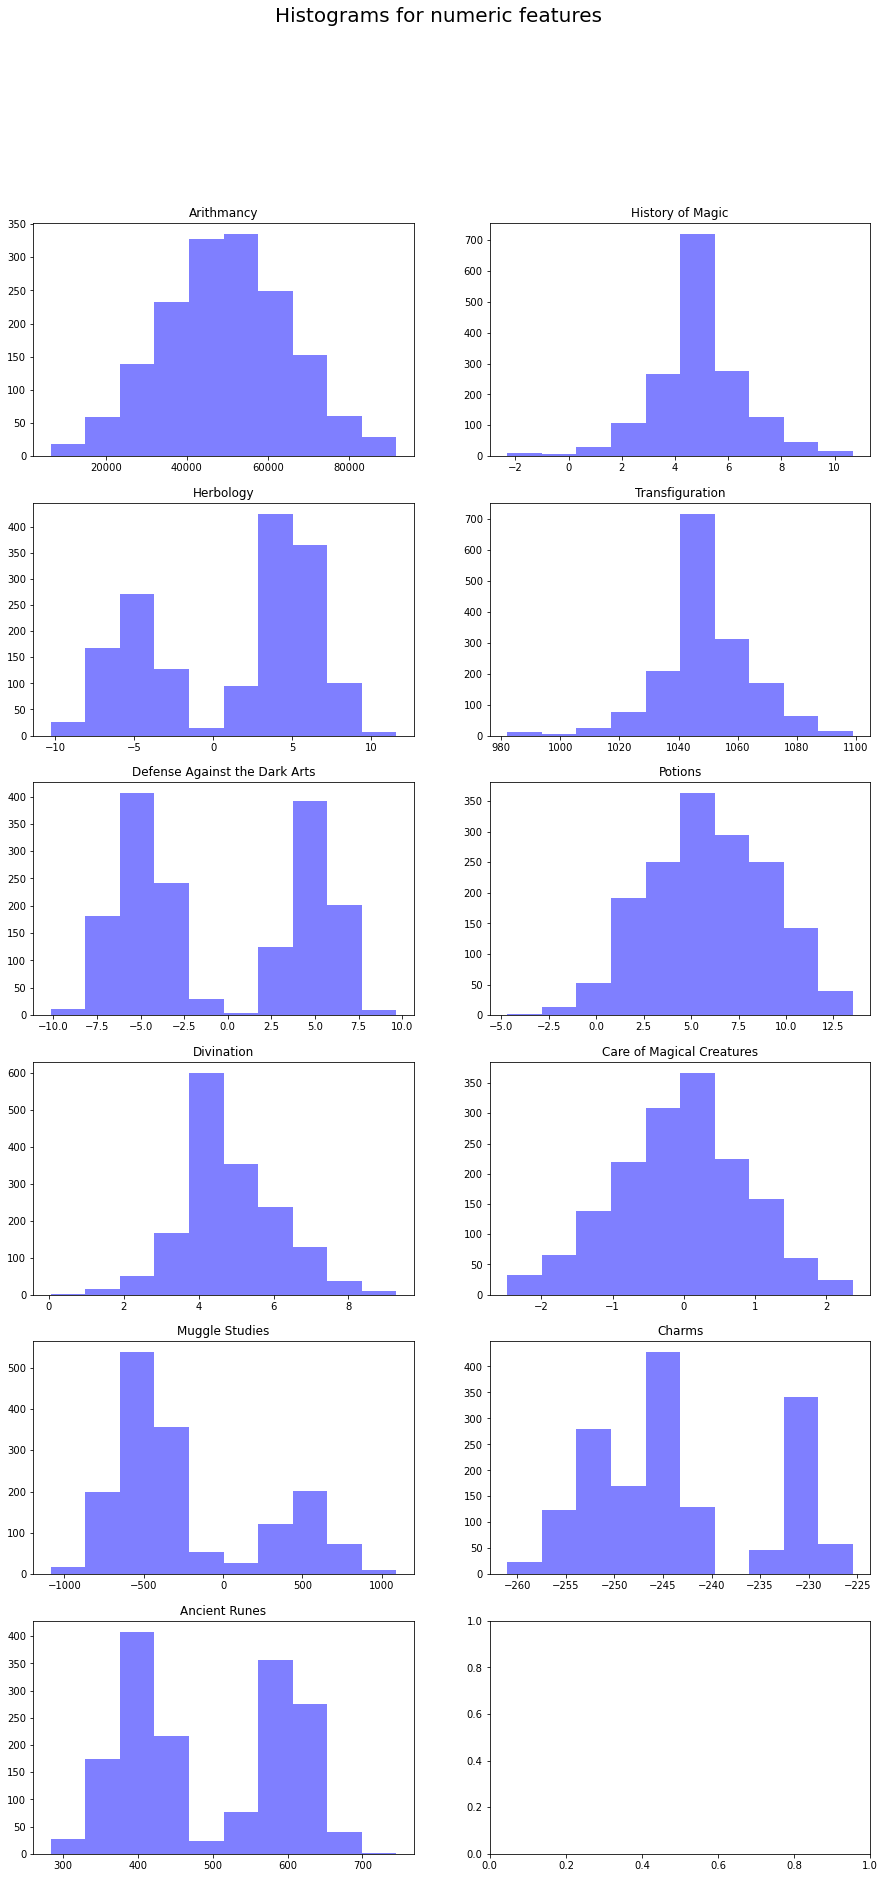

In [102]:
fig, axs = plt.subplots(round(len(num_cols_encoded)/2),2,figsize=(15,30))
plt.suptitle("Histograms for numeric features", fontsize=20)
for i, label in enumerate(num_cols_encoded):
    if i<round(len(num_cols_encoded)/2):
        axs[i, 0].hist(df_num_cols_encoded[label], color='blue', alpha=0.5)
        axs[i, 0].set_title(label)
    else:
        axs[i-(round(len(num_cols_encoded)/2)), 1].hist(df_num_cols_encoded[label], color='blue', alpha=0.5)
        axs[i-(round(len(num_cols_encoded)/2)), 1].set_title(label)

Feature distribution not consistent - normalize data

# Data Normalization
https://www.turing.com/kb/data-normalization-with-python-scikit-learn-tips-tricks-for-data-science

In [103]:
scaler = MinMaxScaler()
df_encoded[num_cols_encoded] = scaler.fit_transform(df_num_cols_encoded)

In [104]:
df_encoded

,Best Hand,Arithmancy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,...,4_Birthday Month,5_Birthday Month,6_Birthday Month,7_Birthday Month,8_Birthday Month,9_Birthday Month,10_Birthday Month,11_Birthday Month,12_Birthday Month,Hogwarts House
0,0,0.610009,0.731351,0.758514,0.505959,0.623499,0.538679,0.579798,0.493765,0.465490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,0.713932,0.196645,0.790877,0.495341,0.274983,0.181768,0.493335,0.657659,0.655153,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
2,0,0.202976,0.822541,0.697086,0.659588,0.803801,0.690568,0.450900,0.907002,0.736308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0,0.308191,0.173377,0.160604,0.430553,0.252191,0.520257,0.514184,0.542692,0.302694,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
4,0,0.630828,0.112971,0.381894,0.236620,0.294754,0.683503,0.514184,0.542692,0.494046,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1,0.499982,0.262629,0.333811,0.612134,0.270442,0.724445,0.514184,0.542692,0.443483,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2
1596,0,0.667656,0.746591,0.327129,0.184724,0.203419,0.350918,0.349544,0.633727,0.577087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1597,1,0.674804,0.323727,0.238126,0.651463,0.321883,0.761260,0.514184,0.542692,0.351388,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
1598,0,0.895537,0.627083,0.283686,0.724377,0.116920,0.215752,0.470712,0.905811,0.471727,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


# Splitting data

In [105]:
y = df_encoded["Hogwarts House"]

In [106]:
X = df_encoded.drop("Hogwarts House", axis=1)
X

,Best Hand,Arithmancy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,...,3_Birthday Month,4_Birthday Month,5_Birthday Month,6_Birthday Month,7_Birthday Month,8_Birthday Month,9_Birthday Month,10_Birthday Month,11_Birthday Month,12_Birthday Month
0,0,0.610009,0.731351,0.758514,0.505959,0.623499,0.538679,0.579798,0.493765,0.465490,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.713932,0.196645,0.790877,0.495341,0.274983,0.181768,0.493335,0.657659,0.655153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,0.202976,0.822541,0.697086,0.659588,0.803801,0.690568,0.450900,0.907002,0.736308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0.308191,0.173377,0.160604,0.430553,0.252191,0.520257,0.514184,0.542692,0.302694,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,0.630828,0.112971,0.381894,0.236620,0.294754,0.683503,0.514184,0.542692,0.494046,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1,0.499982,0.262629,0.333811,0.612134,0.270442,0.724445,0.514184,0.542692,0.443483,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1596,0,0.667656,0.746591,0.327129,0.184724,0.203419,0.350918,0.349544,0.633727,0.577087,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1597,1,0.674804,0.323727,0.238126,0.651463,0.321883,0.761260,0.514184,0.542692,0.351388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1598,0,0.895537,0.627083,0.283686,0.724377,0.116920,0.215752,0.470712,0.905811,0.471727,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Feature Selection
https://ranasinghiitkgp.medium.com/implementing-feature-selection-methods-for-machine-learning-bfa2e4b4e02


## Using Mutual Info Score

In [107]:
MI_score = mutual_info_classif(X, y, random_state=42)
feature_MI_scores = pd.DataFrame(data=MI_score, index=X.columns, columns=["MI_score"]).sort_values(by="MI_score", ascending=False)
feature_MI_scores["feature_ID"] = list(range(1, len(feature_MI_scores)+1))
feature_MI_scores

,MI_score,feature_ID
Charms,0.921241,1
Defense Against the Dark Arts,0.628698,2
Ancient Runes,0.619091,3
Herbology,0.593004,4
Good_at_astronomy,0.571396,5
Muggle Studies,0.505008,6
History of Magic,0.433510,7
Transfiguration,0.402237,8
Divination,0.373210,9
Potions,0.332167,10


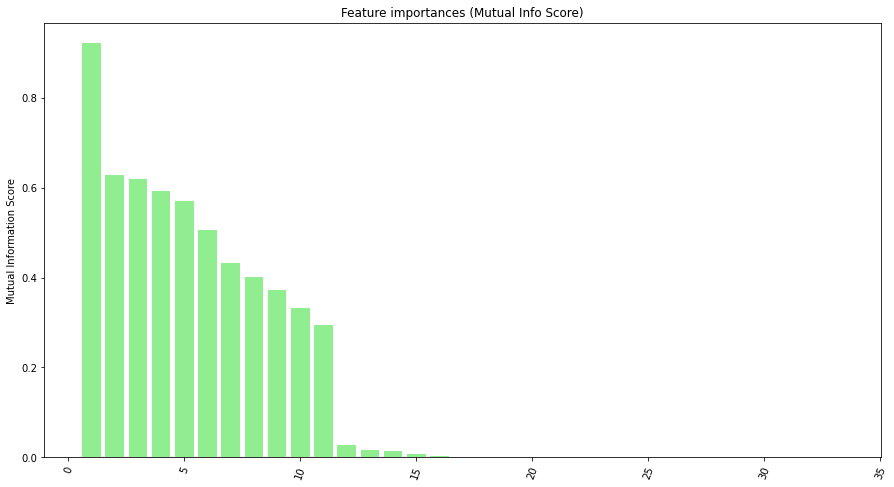

In [108]:
plt.figure(figsize=(15,8));
plt.bar(x=feature_MI_scores["feature_ID"][:len(X.columns)], height=feature_MI_scores["MI_score"][:len(X.columns)], color='lightgreen');
plt.ylabel('Mutual Information Score');
plt.xticks(rotation=70);
plt.title("Feature importances (Mutual Info Score)");

11 best features:

In [109]:
MI_feature_importances = feature_MI_scores[:11]
MI_feature_importances 

,MI_score,feature_ID
Charms,0.921241,1
Defense Against the Dark Arts,0.628698,2
Ancient Runes,0.619091,3
Herbology,0.593004,4
Good_at_astronomy,0.571396,5
Muggle Studies,0.505008,6
History of Magic,0.433510,7
Transfiguration,0.402237,8
Divination,0.373210,9
Potions,0.332167,10


## Using Fisher Score

In [110]:
# pip install skfeature-chappers

In [111]:
fisher_s = fisher_score.fisher_score(X.to_numpy(), y.to_numpy())

In [112]:
feature_fisher_scores = pd.DataFrame(fisher_s, index=X.columns, columns=["Fisher score"])
feature_fisher_scores = feature_fisher_scores.sort_values(by="Fisher score", ascending=False)

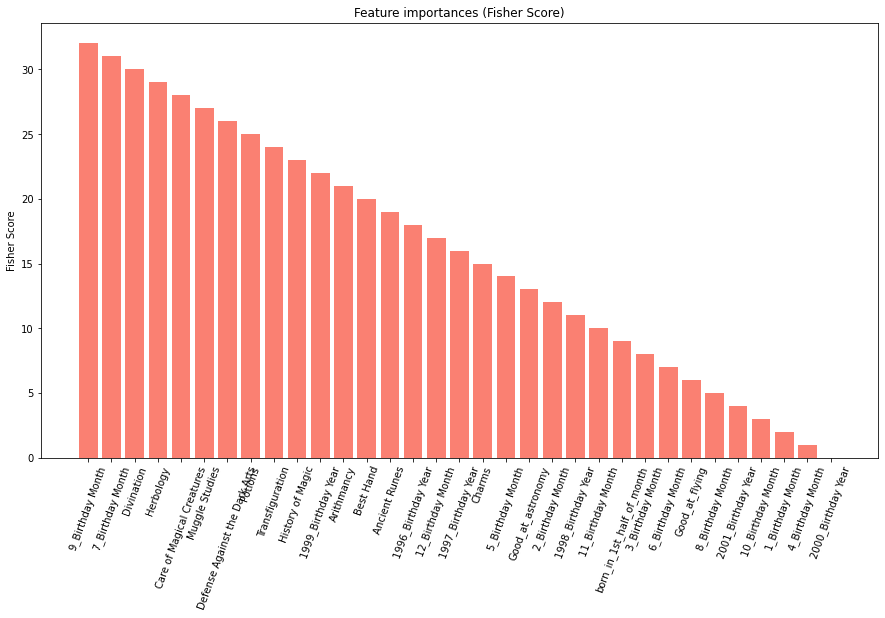

In [113]:
plt.figure(figsize=(15,8));
plt.bar(x=feature_fisher_scores.index[:len(X.columns)], height=feature_fisher_scores["Fisher score"][:len(X.columns)], color='salmon');
plt.ylabel('Fisher Score');
plt.xticks(rotation=70);
plt.title("Feature importances (Fisher Score)");

In [114]:
feature_fisher_scores[:11]

,Fisher score
9_Birthday Month,32
7_Birthday Month,31
Divination,30
Herbology,29
Care of Magical Creatures,28
Muggle Studies,27
Defense Against the Dark Arts,26
Potions,25
Transfiguration,24
History of Magic,23


**For further use: features selected with Mutual Info Score**

# Modeling
using only selected features

In [115]:
X_sel = X[MI_feature_importances.index]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)

In [117]:
def fit_and_score_model(model, X_train, X_test, y_train, y_test):
    '''
    fits model and calculates:
    - accuracy
    - y_pred
    - y_pred_train
    - acc_train
    '''
    
    np.random.seed(42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test) # y_pred_test
    y_pred_train = model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
        
    return score, y_pred, y_pred_train, acc_train

In [118]:
models=[RandomForestClassifier(n_estimators=200, max_depth=3, min_samples_split = 10),
        svm.SVC(kernel='poly', degree=3, C=1),
        KNeighborsClassifier(),
        DecisionTreeClassifier()]


In [119]:
model_metrics = pd.DataFrame(index = ["acc", "acc_train", "acc_cv"], columns=["Random Forest", "SVM", "KNN", "Decision Tree"])

In [120]:
counter=0
for model in models:
    score, y_pred, y_pred_train, acc_train = fit_and_score_model(model, X_train, X_test, y_train, y_test)
    
    score_cv = cross_val_score(model, X_sel, y, cv=5)
    model_metrics.iloc[:, counter] = [score, acc_train, score_cv.mean()]
    
    counter+=1

In [121]:
model_metrics

,Random Forest,SVM,KNN,Decision Tree
acc,0.9875,0.9875,0.9875,0.96875
acc_train,0.980469,0.982031,0.976562,1.0
acc_cv,0.981875,0.98,0.97875,0.964375


## Checking Learining Curves for used classifiers

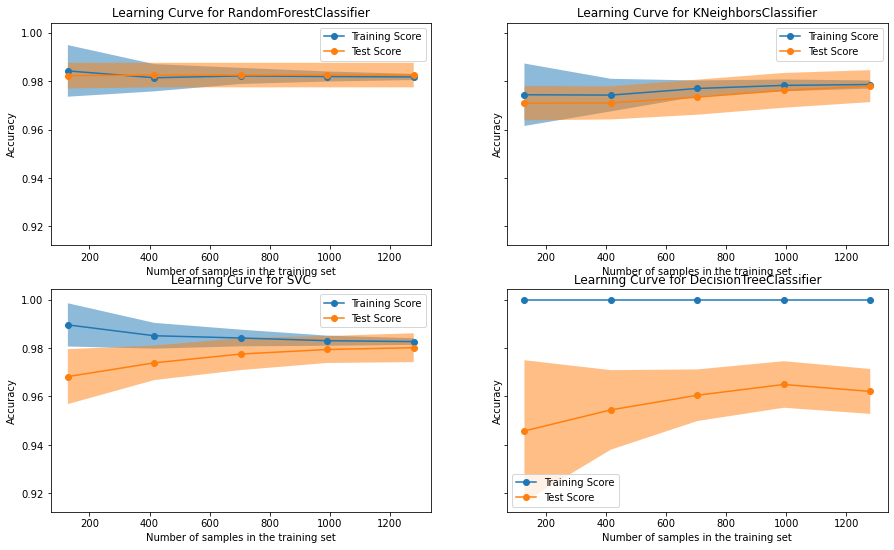

In [122]:
fig, axs = plt.subplots(round(len(models)/2),2 , figsize=(15, 9), sharey=True)

common_params = {"X": X_sel,
                 "y": y,
                 "train_sizes": np.linspace(0.1, 1.0, 5),
                 "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
                 "score_type": "both",
                 "n_jobs": 4,
                 "line_kw": {"marker": "o"},
                 "std_display_style": "fill_between",
                 "score_name": "Accuracy"}
col=0
i=0
for model in models:
    LearningCurveDisplay.from_estimator(model, **common_params, ax=axs[i, col])
    handles, label = axs[i, col].get_legend_handles_labels()
    axs[i, col].legend(handles[:2], ["Training Score", "Test Score"])
    axs[i, col].set_title(f"Learning Curve for {model.__class__.__name__}")
    i+=1
    
    if i>=round(len(models)/2):
        col+=1
        i=0

# Final Model - Random Forest

### Tuning hyperparameters using Randomized Search

In [123]:
rf_grid = {"n_estimators": np.arange(50,500, 50),
           "max_depth": [None, 3, 5, 8],
           "min_samples_split": np.arange(8, 20, 1),
           "min_samples_leaf":np.arange(8, 20, 1)}

In [124]:
model = RandomForestClassifier()

In [125]:
np.random.seed(42)

rs_rf = RandomizedSearchCV(model,
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=3)

rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_depth=None, min_samples_leaf=15, min_samples_split=19, n_estimators=300;, score=0.980 total time=   0.5s
[CV 2/5] END max_depth=None, min_samples_leaf=15, min_samples_split=19, n_estimators=300;, score=0.992 total time=   0.5s
[CV 3/5] END max_depth=None, min_samples_leaf=15, min_samples_split=19, n_estimators=300;, score=0.980 total time=   0.5s
[CV 4/5] END max_depth=None, min_samples_leaf=15, min_samples_split=19, n_estimators=300;, score=0.980 total time=   0.5s
[CV 5/5] END max_depth=None, min_samples_leaf=15, min_samples_split=19, n_estimators=300;, score=0.969 total time=   0.5s
[CV 1/5] END max_depth=5, min_samples_leaf=18, min_samples_split=19, n_estimators=100;, score=0.980 total time=   0.1s
[CV 2/5] END max_depth=5, min_samples_leaf=18, min_samples_split=19, n_estimators=100;, score=0.992 total time=   0.1s
[CV 3/5] END max_depth=5, min_samples_leaf=18, min_samples_split=19, n_estimators=100;, sc

[CV 4/5] END max_depth=8, min_samples_leaf=18, min_samples_split=17, n_estimators=150;, score=0.980 total time=   0.2s
[CV 5/5] END max_depth=8, min_samples_leaf=18, min_samples_split=17, n_estimators=150;, score=0.969 total time=   0.2s
[CV 1/5] END max_depth=None, min_samples_leaf=18, min_samples_split=19, n_estimators=300;, score=0.980 total time=   0.5s
[CV 2/5] END max_depth=None, min_samples_leaf=18, min_samples_split=19, n_estimators=300;, score=0.992 total time=   0.5s
[CV 3/5] END max_depth=None, min_samples_leaf=18, min_samples_split=19, n_estimators=300;, score=0.980 total time=   0.5s
[CV 4/5] END max_depth=None, min_samples_leaf=18, min_samples_split=19, n_estimators=300;, score=0.980 total time=   0.5s
[CV 5/5] END max_depth=None, min_samples_leaf=18, min_samples_split=19, n_estimators=300;, score=0.969 total time=   0.5s
[CV 1/5] END max_depth=8, min_samples_leaf=14, min_samples_split=10, n_estimators=100;, score=0.980 total time=   0.1s
[CV 2/5] END max_depth=8, min_sam

In [126]:
rs_rf.best_params_

{'n_estimators': 300,
 'min_samples_split': 19,
 'min_samples_leaf': 15,
 'max_depth': None}

In [127]:
rs_rf.score(X_test,y_test)

0.9875

### Evalueating model with best params

In [128]:
model = RandomForestClassifier(n_estimators=300,
                               min_samples_split=19,
                               min_samples_leaf=15,
                               max_depth = None);

score, y_pred, y_pred_train, acc_train = fit_and_score_model(model, X_train, X_test, y_train, y_test);

In [129]:
from sklearn.preprocessing import LabelBinarizer

In [130]:
# Transform y into binary
label_binarizer = LabelBinarizer()
y_test_binary = label_binarizer.fit_transform(y_test)
y_pred_binary = label_binarizer.transform(y_pred)

In [131]:
# Calculating roc auc score on multiclass data
roc_auc = roc_auc_score(y_test_binary, y_pred_binary, average='macro')

In [132]:
roc_auc

0.9930217647967622

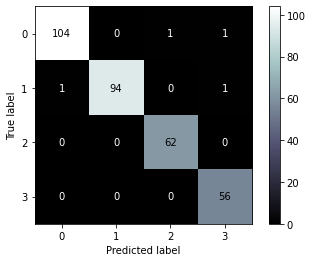

In [133]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="bone");

In [134]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       106
           1       1.00      0.98      0.99        96
           2       0.98      1.00      0.99        62
           3       0.97      1.00      0.98        56

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



Text(0.5, 1.0, 'Learning curve - final model')

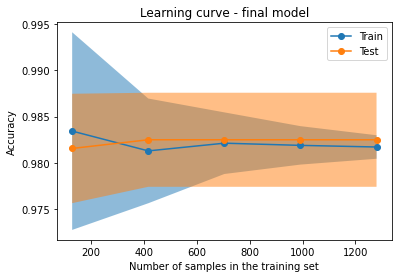

In [135]:
LearningCurveDisplay.from_estimator(model, **common_params);
plt.title("Learning curve - final model")

In [140]:
# New data - slytherin student
X_new_student = pd.DataFrame({"Charms": -250,
                     "Defense Against the Dark Arts": 5,
                     "Ancient Runes": 360,
                     "Herbology": -5,
                     "Good_at_astronomy": 0,
                     "Muggle Studies": -480,
                     "History of Magic": 4,
                     "Transfiguration": 1000,
                     "Divination": -5,
                     "Potions": 7,
                     "Good_at_flying": 0},
                     index=[0])

In [141]:
X_new_student

,Charms,Defense Against the Dark Arts,Ancient Runes,Herbology,Good_at_astronomy,Muggle Studies,History of Magic,Transfiguration,Divination,Potions,Good_at_flying
0,-250,5,360,-5,0,-480,4,1000,-5,7,0


* Hufflepuff: 0
* Ravenclaw: 1
* Gryffindor: 2
* Slytherin: 3

In [142]:
model.predict(X_new_student)

array([3], dtype=int64)